In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [7]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [8]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [9]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [10]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [11]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [12]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [13]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [14]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:50,  2.35it/s]


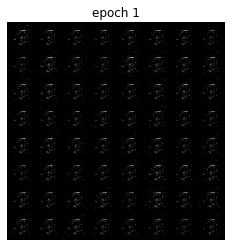

Epoch 1 of 100
Generator loss: 1.34044480, Discriminator loss: 0.89347965


118it [00:49,  2.37it/s]


Epoch 2 of 100
Generator loss: 1.71227658, Discriminator loss: 1.39107263


118it [00:50,  2.36it/s]


Epoch 3 of 100
Generator loss: 3.53017759, Discriminator loss: 0.85732102


118it [00:49,  2.40it/s]


Epoch 4 of 100
Generator loss: 1.68752396, Discriminator loss: 1.35498202


118it [00:48,  2.45it/s]


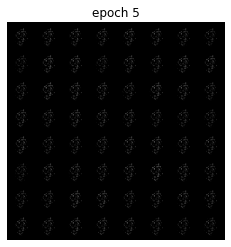

Epoch 5 of 100
Generator loss: 1.30940568, Discriminator loss: 1.14386237


118it [00:49,  2.38it/s]


Epoch 6 of 100
Generator loss: 1.59310746, Discriminator loss: 1.03158879


118it [00:50,  2.34it/s]


Epoch 7 of 100
Generator loss: 1.94979584, Discriminator loss: 1.08912790


118it [00:50,  2.35it/s]


Epoch 8 of 100
Generator loss: 1.23390615, Discriminator loss: 1.17574596


118it [00:49,  2.39it/s]


Epoch 9 of 100
Generator loss: 1.84295082, Discriminator loss: 1.03478992


118it [00:55,  2.13it/s]


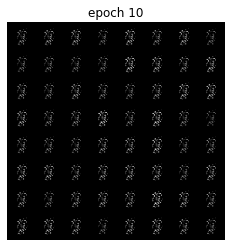

Epoch 10 of 100
Generator loss: 1.58784008, Discriminator loss: 1.24682796


118it [00:50,  2.36it/s]


Epoch 11 of 100
Generator loss: 1.81692636, Discriminator loss: 1.14483035


118it [00:54,  2.18it/s]


Epoch 12 of 100
Generator loss: 1.48250568, Discriminator loss: 1.11413765


118it [00:52,  2.27it/s]


Epoch 13 of 100
Generator loss: 1.61837399, Discriminator loss: 1.14764631


118it [00:50,  2.34it/s]


Epoch 14 of 100
Generator loss: 1.59769392, Discriminator loss: 1.22027147


118it [00:49,  2.38it/s]


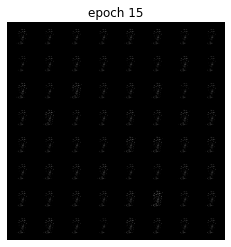

Epoch 15 of 100
Generator loss: 0.92935914, Discriminator loss: 1.22591305


118it [00:48,  2.41it/s]


Epoch 16 of 100
Generator loss: 1.41978931, Discriminator loss: 1.05885041


118it [00:48,  2.43it/s]


Epoch 17 of 100
Generator loss: 1.80049086, Discriminator loss: 1.09025788


118it [00:49,  2.39it/s]


Epoch 18 of 100
Generator loss: 2.24782658, Discriminator loss: 0.81828338


118it [00:48,  2.42it/s]


Epoch 19 of 100
Generator loss: 1.82181931, Discriminator loss: 1.22691298


118it [00:47,  2.49it/s]


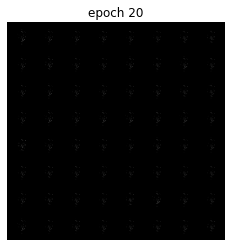

Epoch 20 of 100
Generator loss: 1.28917742, Discriminator loss: 0.91694570


118it [00:48,  2.41it/s]


Epoch 21 of 100
Generator loss: 1.29862118, Discriminator loss: 1.02183354


118it [00:49,  2.40it/s]


Epoch 22 of 100
Generator loss: 2.31174207, Discriminator loss: 0.83633769


118it [00:49,  2.37it/s]


Epoch 23 of 100
Generator loss: 1.65986276, Discriminator loss: 0.84451199


118it [00:49,  2.38it/s]


Epoch 24 of 100
Generator loss: 1.83249748, Discriminator loss: 0.95016056


118it [00:48,  2.44it/s]


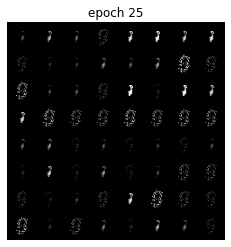

Epoch 25 of 100
Generator loss: 2.04824424, Discriminator loss: 0.79202878


118it [00:49,  2.39it/s]


Epoch 26 of 100
Generator loss: 2.08214188, Discriminator loss: 0.64926088


118it [00:49,  2.39it/s]


Epoch 27 of 100
Generator loss: 2.60412979, Discriminator loss: 0.47351810


118it [00:49,  2.38it/s]


Epoch 28 of 100
Generator loss: 2.68565941, Discriminator loss: 0.81451166


118it [00:49,  2.36it/s]


Epoch 29 of 100
Generator loss: 2.73533583, Discriminator loss: 0.71140248


118it [00:49,  2.38it/s]


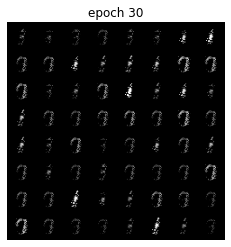

Epoch 30 of 100
Generator loss: 2.91952825, Discriminator loss: 0.60956645


118it [00:50,  2.31it/s]


Epoch 31 of 100
Generator loss: 2.77897167, Discriminator loss: 0.58460832


118it [00:49,  2.39it/s]


Epoch 32 of 100
Generator loss: 2.74667192, Discriminator loss: 0.55927533


118it [00:49,  2.38it/s]


Epoch 33 of 100
Generator loss: 2.28420210, Discriminator loss: 0.76933587


118it [00:49,  2.39it/s]


Epoch 34 of 100
Generator loss: 2.28494096, Discriminator loss: 0.68350649


118it [00:49,  2.39it/s]


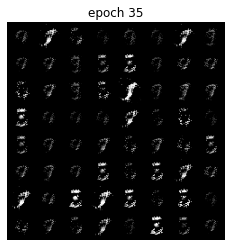

Epoch 35 of 100
Generator loss: 2.03098679, Discriminator loss: 0.80570477


118it [00:49,  2.39it/s]


Epoch 36 of 100
Generator loss: 2.10732818, Discriminator loss: 0.75985420


118it [00:49,  2.39it/s]


Epoch 37 of 100
Generator loss: 2.23440933, Discriminator loss: 0.60327995


118it [00:48,  2.42it/s]


Epoch 38 of 100
Generator loss: 2.53782272, Discriminator loss: 0.55819225


118it [00:49,  2.36it/s]


Epoch 39 of 100
Generator loss: 2.54804635, Discriminator loss: 0.58052111


118it [00:50,  2.36it/s]


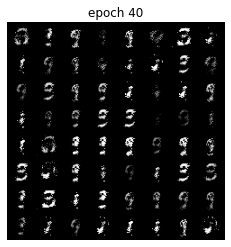

Epoch 40 of 100
Generator loss: 2.69042921, Discriminator loss: 0.51008040


118it [00:49,  2.39it/s]


Epoch 41 of 100
Generator loss: 2.84383321, Discriminator loss: 0.50258809


118it [00:49,  2.39it/s]


Epoch 42 of 100
Generator loss: 2.98678517, Discriminator loss: 0.46812272


118it [00:50,  2.35it/s]


Epoch 43 of 100
Generator loss: 2.73706079, Discriminator loss: 0.59191978


118it [00:49,  2.39it/s]


Epoch 44 of 100
Generator loss: 3.25955439, Discriminator loss: 0.56594473


118it [00:50,  2.33it/s]


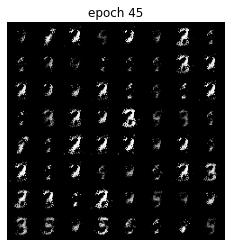

Epoch 45 of 100
Generator loss: 2.82040644, Discriminator loss: 0.57092685


118it [00:49,  2.38it/s]


Epoch 46 of 100
Generator loss: 2.97784925, Discriminator loss: 0.53309244


118it [00:49,  2.38it/s]


Epoch 47 of 100
Generator loss: 2.90332866, Discriminator loss: 0.53181714


118it [00:48,  2.42it/s]


Epoch 48 of 100
Generator loss: 3.07669067, Discriminator loss: 0.47946686


118it [00:49,  2.39it/s]


Epoch 49 of 100
Generator loss: 3.28534269, Discriminator loss: 0.43427238


118it [00:50,  2.35it/s]


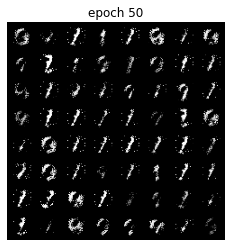

Epoch 50 of 100
Generator loss: 2.84855628, Discriminator loss: 0.55082917


118it [00:50,  2.34it/s]


Epoch 51 of 100
Generator loss: 2.79135966, Discriminator loss: 0.50239533


118it [00:49,  2.38it/s]


Epoch 52 of 100
Generator loss: 3.17780161, Discriminator loss: 0.43877167


118it [00:48,  2.42it/s]


Epoch 53 of 100
Generator loss: 3.39926863, Discriminator loss: 0.42004374


118it [00:49,  2.38it/s]


Epoch 54 of 100
Generator loss: 3.21445155, Discriminator loss: 0.45517153


118it [00:50,  2.34it/s]


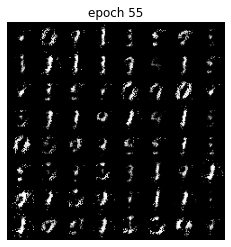

Epoch 55 of 100
Generator loss: 3.41925168, Discriminator loss: 0.43076685


118it [00:51,  2.31it/s]


Epoch 56 of 100
Generator loss: 3.12554955, Discriminator loss: 0.49773955


118it [00:49,  2.37it/s]


Epoch 57 of 100
Generator loss: 3.47896338, Discriminator loss: 0.40297490


118it [00:49,  2.40it/s]


Epoch 58 of 100
Generator loss: 3.28825736, Discriminator loss: 0.44165942


118it [00:49,  2.38it/s]


Epoch 59 of 100
Generator loss: 3.37576413, Discriminator loss: 0.41481975


118it [00:49,  2.38it/s]


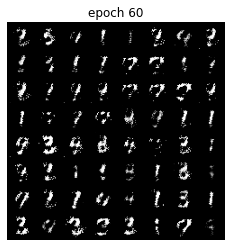

Epoch 60 of 100
Generator loss: 3.29174614, Discriminator loss: 0.45551500


118it [00:50,  2.33it/s]


Epoch 61 of 100
Generator loss: 3.22184730, Discriminator loss: 0.45555681


118it [00:49,  2.38it/s]


Epoch 62 of 100
Generator loss: 2.98285913, Discriminator loss: 0.50072414


118it [00:49,  2.37it/s]


Epoch 63 of 100
Generator loss: 2.91797638, Discriminator loss: 0.49412528


118it [00:49,  2.40it/s]


Epoch 64 of 100
Generator loss: 3.04145765, Discriminator loss: 0.46627611


118it [00:50,  2.35it/s]


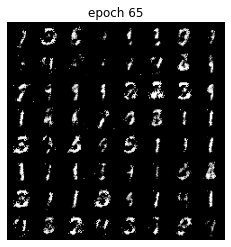

Epoch 65 of 100
Generator loss: 3.18811607, Discriminator loss: 0.49558035


118it [00:50,  2.33it/s]


Epoch 66 of 100
Generator loss: 2.93410754, Discriminator loss: 0.50451386


118it [00:49,  2.37it/s]


Epoch 67 of 100
Generator loss: 2.80035424, Discriminator loss: 0.54243183


118it [00:49,  2.38it/s]


Epoch 68 of 100
Generator loss: 2.72108293, Discriminator loss: 0.53416115


118it [00:49,  2.39it/s]


Epoch 69 of 100
Generator loss: 2.88844371, Discriminator loss: 0.50306720


118it [00:49,  2.37it/s]


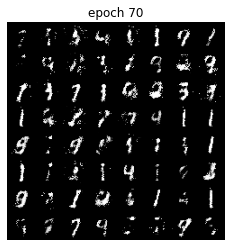

Epoch 70 of 100
Generator loss: 2.89301658, Discriminator loss: 0.50161868


118it [00:49,  2.37it/s]


Epoch 71 of 100
Generator loss: 2.86466908, Discriminator loss: 0.51057488


118it [00:49,  2.37it/s]


Epoch 72 of 100
Generator loss: 2.87404776, Discriminator loss: 0.51622546


118it [00:48,  2.42it/s]


Epoch 73 of 100
Generator loss: 2.69514275, Discriminator loss: 0.52567279


118it [00:48,  2.45it/s]


Epoch 74 of 100
Generator loss: 2.75935745, Discriminator loss: 0.55374271


118it [00:49,  2.38it/s]


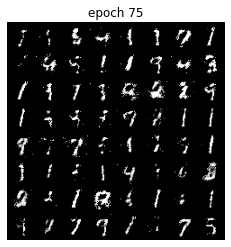

Epoch 75 of 100
Generator loss: 2.49158669, Discriminator loss: 0.56062788


118it [00:50,  2.34it/s]


Epoch 76 of 100
Generator loss: 2.70967841, Discriminator loss: 0.52892911


118it [00:50,  2.35it/s]


Epoch 77 of 100
Generator loss: 2.60853839, Discriminator loss: 0.56678712


118it [00:49,  2.36it/s]


Epoch 78 of 100
Generator loss: 2.64622331, Discriminator loss: 0.55414206


118it [00:50,  2.33it/s]


Epoch 79 of 100
Generator loss: 2.58156562, Discriminator loss: 0.57674205


118it [00:51,  2.30it/s]


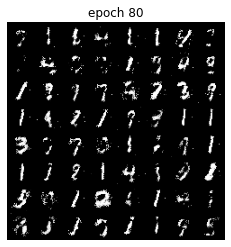

Epoch 80 of 100
Generator loss: 2.58451033, Discriminator loss: 0.56522894


118it [00:50,  2.35it/s]


Epoch 81 of 100
Generator loss: 2.48301125, Discriminator loss: 0.61936969


118it [00:51,  2.27it/s]


Epoch 82 of 100
Generator loss: 2.36823082, Discriminator loss: 0.63398147


118it [00:50,  2.34it/s]


Epoch 83 of 100
Generator loss: 2.32667160, Discriminator loss: 0.67335320


118it [00:51,  2.28it/s]


Epoch 84 of 100
Generator loss: 2.29448724, Discriminator loss: 0.67643291


118it [00:51,  2.31it/s]


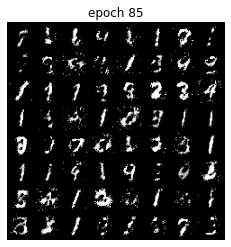

Epoch 85 of 100
Generator loss: 2.21039343, Discriminator loss: 0.69224989


118it [00:50,  2.32it/s]


Epoch 86 of 100
Generator loss: 2.20190001, Discriminator loss: 0.66852552


118it [00:51,  2.31it/s]


Epoch 87 of 100
Generator loss: 2.26819372, Discriminator loss: 0.63253939


118it [00:52,  2.26it/s]


Epoch 88 of 100
Generator loss: 2.22039270, Discriminator loss: 0.64867234


118it [00:50,  2.35it/s]


Epoch 89 of 100
Generator loss: 2.29795814, Discriminator loss: 0.65377879


118it [00:51,  2.28it/s]


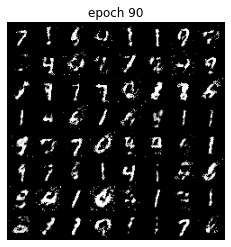

Epoch 90 of 100
Generator loss: 2.12947464, Discriminator loss: 0.70552284


118it [00:52,  2.26it/s]


Epoch 91 of 100
Generator loss: 2.11414075, Discriminator loss: 0.70156461


118it [00:52,  2.24it/s]


Epoch 92 of 100
Generator loss: 2.10927105, Discriminator loss: 0.70368207


118it [00:52,  2.24it/s]


Epoch 93 of 100
Generator loss: 2.09193420, Discriminator loss: 0.74350852


118it [00:51,  2.30it/s]


Epoch 94 of 100
Generator loss: 2.20073390, Discriminator loss: 0.70326871


118it [00:52,  2.25it/s]


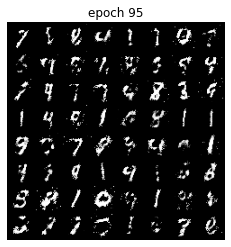

Epoch 95 of 100
Generator loss: 1.95266175, Discriminator loss: 0.76004261


118it [00:51,  2.28it/s]


Epoch 96 of 100
Generator loss: 1.96079767, Discriminator loss: 0.78871363


118it [00:52,  2.25it/s]


Epoch 97 of 100
Generator loss: 2.02452803, Discriminator loss: 0.76920617


118it [00:52,  2.26it/s]


Epoch 98 of 100
Generator loss: 2.03947687, Discriminator loss: 0.76596230


118it [00:51,  2.31it/s]


Epoch 99 of 100
Generator loss: 1.99240685, Discriminator loss: 0.80310822


118it [00:51,  2.29it/s]


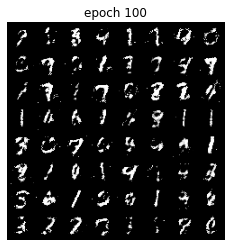

Epoch 100 of 100
Generator loss: 1.94334054, Discriminator loss: 0.77391231


In [15]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    loss = criterion(output, true_label)
    return loss
    
    
def discriminator_loss(output, true_label):
    loss = criterion(output, true_label)
    return loss
    


for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            b_size = data_real.size(0)
            real_label = label_real(b_size)
            fake_label = label_fake(b_size)
            optim_d.zero_grad()
            output_real = discriminator(data_real)
            loss_real = discriminator_loss(output_real, real_label)
            output_fake = discriminator(data_fake)
            loss_fake = discriminator_loss(output_fake, fake_label)
            loss_real.backward()
            loss_fake.backward()
            optim_d.step()
            loss_d += loss_real + loss_fake
        data_fake = generator(create_noise(b_size, nz))
        b_size = data_fake.size(0)
        real_label = label_real(b_size)
        optim_g.zero_grad()
        output = discriminator(data_fake)
        loss = generator_loss(output, real_label)
        loss.backward()
        optim_g.step()
        loss_g += loss
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0 or (epoch + 1) == 1:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [16]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [17]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

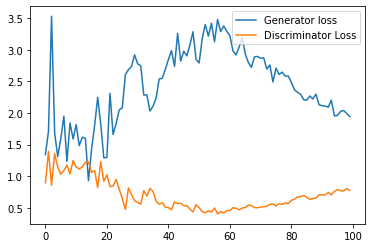

In [18]:
# plot and save the generator and discriminator loss
plt.figure()
generator_loss = []
discriminator_loss = []
for i in losses_g:
  val = i.detach().numpy()
  generator_loss.append(float(i))
for i in losses_d:
  val = i.detach().numpy()
  discriminator_loss.append(float(i))
plt.plot(generator_loss, label='Generator loss')
plt.plot(discriminator_loss, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')